# High OSK vs iPSC MoDISco

Compare high OSK vs iPSC Modisco motif log-odds as per BPNet OS motif.

In [1]:
import modisco
import h5py
import deepdish
import intervaltree
from collections import defaultdict, OrderedDict, Counter
from modisco.visualization import viz_sequence
import matplotlib

# for pdf text saving 
matplotlib.rcParams['pdf.fonttype'] = 42

from matplotlib import pyplot as plt
import numpy as np
import tqdm
import modisco
from modisco.visualization import viz_sequence
import tqdm
import pyBigWig
import pyfaidx

In [2]:
!pip freeze | grep modisco

modisco @ git+https://github.com/kundajelab/tfmodisco.git@d1fdb21ed0c8b4e33c835be29955a8426a422693


In [12]:
import os

In [13]:
os.environ["HDF5_USE_FILE_LOCKING"] = "FALSE"

In [14]:
def revcomp(x):
    # Assuming ACGT
    return x[::-1][:,::-1]

## Load Data

In [15]:
# will crop to this region around center (summit of peak) [this is what was done for this data when modisco was called]
MODISCO_CROP_WIDTH = 500

In [16]:
hg38 = pyfaidx.Fasta("/users/surag/genomes/hg38/GRCh38_no_alt_analysis_set_GCA_000001405.15.fasta")

In [8]:
def get_regions(regions_file, crop_width):
    with open(regions_file) as f:
        scored_regions = [x.strip().split('\t') for x in f]

    # importance scores are computed centered at summit (2nd col + 10th col)
    scored_regions = [(x[0], int(x[9])+int(x[1])-crop_width//2, int(x[9])+int(x[1])+crop_width//2) for x in scored_regions]
    
    return scored_regions

In [9]:
def fetch_data(modisco_hdf5, pattern_name, pattern_start, pattern_end,
               imp_scores, regions, insertions_bw_file, 
               pred_w_bias_bw_file, pred_wo_bias_bw_file, 
               modisco_crop_width, genome, rc_everything=False, expand_bw=100):
    """
    this function basically goes through the seqlets of a given pattern (pattern_name)
    it pulls out raw shap scores for each seqlet, its coordinates, whether it's RC-ed,
    its subcluster indices
    also pulls out raw insertions for each seqlet (out expand_bw on both sides), and same
    for predicted profiles w/ and w/o bias 
    
    returned seqlets all have the same orientation!
    pattern_start -> start of pattern within seqlet ([0,seqlen_len)]
    pattern_end-> start of pattern within seqlen ((pattern_start,seqlen_len)]
    """
    
    assert(len(regions)==imp_scores['shap']['seq'].shape[0])
    
    # region sliced out and used for modisco
    imp_width = imp_scores['shap']['seq'].shape[-1]
    imp_crop_start = imp_width//2 - modisco_crop_width//2
    imp_crop_end = imp_width//2 + modisco_crop_width//2
    
    pattern = modisco_hdf5['metacluster_idx_to_submetacluster_results']['metacluster_0']['seqlets_to_patterns_result']['patterns'][pattern_name]
    
    seqlet_len = pattern["sequence"]["fwd"].shape[0]
    
    subcluster_idxs = np.array(list(pattern["subclusters"]))
    
    insertions_bw = pyBigWig.open(insertions_bw_file)
    pred_w_bias_bw = pyBigWig.open(pred_w_bias_bw_file)
    pred_wo_bias_bw = pyBigWig.open(pred_wo_bias_bw_file)
    
    seqlet_coords = []
    seqlet_is_rc = []
    seqlet_shaps = []
    seqlet_one_hots = []
    seqlet_pred_wo_bias = []
    seqlet_pred_w_bias = []
    seqlet_insertions = []
    
    # fetch info from the bigwigs where the seqlets are present
    for i in tqdm.trange(len(pattern['seqlets_and_alnmts']['seqlets'])):
        x = pattern['seqlets_and_alnmts']['seqlets'][i]
        
        # index into regions/imp_scores, i.e. which entry in regions does each seqlet come from
        idx = int(x.decode('utf8').split(',')[0].split(':')[1])
        start = int(x.decode('utf8').split(',')[1].split(':')[1])
        rc = eval(x.decode('utf8').split(',')[3].split(':')[1])

        reg = regions[idx]

        cur_proj_shap_scores = imp_scores['projected_shap']['seq'][idx][:, imp_crop_start:imp_crop_end].transpose()
        cur_one_hot = imp_scores['raw']['seq'][idx][:, imp_crop_start:imp_crop_end].transpose()

        seqlet_is_rc.append(rc)
        
        if rc:
            seqlet_shaps.append(revcomp(cur_proj_shap_scores[start+(seqlet_len-pattern_end):start+(seqlet_len-pattern_start)]))
            seqlet_one_hots.append(revcomp(cur_one_hot[start+(seqlet_len-pattern_end):start+(seqlet_len-pattern_start)]))

            start_coord = reg[1]+start+(seqlet_len-pattern_end)
            end_coord = reg[1]+start+(seqlet_len-pattern_start)
            seqlet_coords.append([reg[0], start_coord, end_coord])
            
            start_coord_expanded = start_coord - expand_bw
            end_coord_expanded = end_coord + expand_bw
            
            seqlet_pred_wo_bias.append(np.nan_to_num(pred_wo_bias_bw.values(reg[0], start_coord_expanded, end_coord_expanded))[::-1])
            seqlet_pred_w_bias.append(np.nan_to_num(pred_w_bias_bw.values(reg[0], start_coord_expanded, end_coord_expanded))[::-1])
            seqlet_insertions.append(np.nan_to_num(insertions_bw.values(reg[0], start_coord_expanded, end_coord_expanded))[::-1])

        else:
            seqlet_shaps.append(cur_proj_shap_scores[start+pattern_start:start+pattern_end])
            seqlet_one_hots.append(cur_one_hot[start+pattern_start:start+pattern_end])
            
            start_coord = reg[1]+start+pattern_start
            end_coord = reg[1]+start+pattern_end
            seqlet_coords.append([reg[0], start_coord, end_coord])
            
            start_coord_expanded = start_coord - expand_bw
            end_coord_expanded = end_coord + expand_bw

            seqlet_pred_wo_bias.append(np.nan_to_num(pred_wo_bias_bw.values(reg[0], start_coord_expanded, end_coord_expanded)))
            seqlet_pred_w_bias.append(np.nan_to_num(pred_w_bias_bw.values(reg[0], start_coord_expanded, end_coord_expanded)))    
            seqlet_insertions.append(np.nan_to_num(insertions_bw.values(reg[0], start_coord_expanded, end_coord_expanded)))
    
    insertions_bw.close()
    pred_w_bias_bw.close()
    pred_wo_bias_bw.close()
    
    # RC-ing all instances
    seqlet_shaps = np.array(seqlet_shaps) #[:,::-1,::-1]
    seqlet_one_hots = np.array(seqlet_one_hots)  # [:,::-1,::-1]
    seqlet_pred_wo_bias = np.array(seqlet_pred_wo_bias)
    seqlet_pred_w_bias = np.array(seqlet_pred_w_bias)
    seqlet_insertions = np.array(seqlet_insertions)
    
    if rc_everything:
        seqlet_shaps = seqlet_shaps[:, ::-1, ::-1]
        seqlet_one_hots = seqlet_one_hots[:, ::-1, ::-1]
        seqlet_pred_wo_bias = seqlet_pred_wo_bias[:, ::-1]
        seqlet_pred_w_bias = seqlet_pred_w_bias[:, ::-1]
        seqlet_insertions = seqlet_insertions[:, ::-1]
    
    return seqlet_coords, seqlet_is_rc, subcluster_idxs, seqlet_shaps, seqlet_one_hots, seqlet_insertions, seqlet_pred_w_bias, seqlet_pred_wo_bias

### High OSK MoDISco

In [10]:
HIGH_OSK_MODISCO_PATH = "/users/surag/oak/projects/scATAC-reprog/bpnet/models/20210820_chrombpnet_lite/chrombpnet/cluster_idx11/modisco/modisco_results_allChroms_counts.hdf5"
HIGH_OSK_HDF5_PATH = "/users/surag/oak/projects/scATAC-reprog/bpnet/models/20210820_chrombpnet_lite/chrombpnet/cluster_idx11/interpret/counts_scores.h5"
HIGH_OSK_REG_PATH = "/users/surag/oak/projects/scATAC-reprog/bpnet/models/20210820_chrombpnet_lite/chrombpnet/cluster_idx11/interpret/interpreted_regions.bed"

In [17]:
high_OSK_modisco = h5py.File(HIGH_OSK_MODISCO_PATH, 'r')

In [18]:
high_OSK_imp_scores = deepdish.io.load(HIGH_OSK_HDF5_PATH)

In [19]:
high_OSK_regions = get_regions(HIGH_OSK_REG_PATH, MODISCO_CROP_WIDTH)

In [20]:
# patterns

# OS: pattern_0 : 8 - 24
# KLF: pattern_1 : 6 - 16

In [21]:
high_OSK_coords, high_OSK_is_rc, \
high_OSK_subcluster_idxs, \
high_OSK_shaps, high_OSK_one_hots, \
high_OSK_insertions, high_OSK_pred_w_bias,\
high_OSK_pred_wo_bias = \
        fetch_data(high_OSK_modisco, "pattern_0", 8, 24,
                   high_OSK_imp_scores, high_OSK_regions, 
                   "/users/surag/oak/projects/scATAC-reprog/clusters/20210714_n64913/bigwigs/cluster_idx11.bw", 
                   "/users/surag/oak/projects/scATAC-reprog/bpnet/models/20210820_chrombpnet_lite/chrombpnet/cluster_idx11/predict/cluster_idx11_w_bias.bw",
                   "/users/surag/oak/projects/scATAC-reprog/bpnet/models/20210820_chrombpnet_lite/chrombpnet/cluster_idx11/predict/cluster_idx11_wo_bias.bw",
                   MODISCO_CROP_WIDTH, hg38, rc_everything=True, expand_bw=100)

100%|██████████| 9502/9502 [00:41<00:00, 231.11it/s]


In [22]:
high_OSK_one_hots.shape

(9502, 16, 4)

In [23]:
Counter(high_OSK_subcluster_idxs).most_common()

[(0, 2115),
 (1, 1648),
 (2, 1638),
 (3, 1519),
 (4, 1386),
 (5, 506),
 (6, 215),
 (7, 210),
 (8, 146),
 (9, 60),
 (10, 33),
 (11, 15),
 (12, 11)]

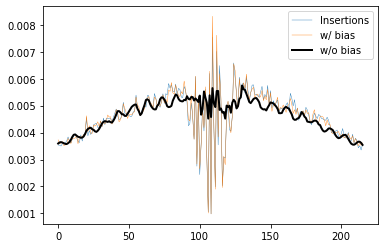

In [22]:
plt.plot(np.array([x/sum(x) for x in high_OSK_insertions if sum(x)>0]).mean(0), label="Insertions", linewidth=0.4)
plt.plot(np.array([x/sum(x) for x in high_OSK_pred_w_bias]).mean(0), label="w/ bias", linewidth=0.4)
plt.plot(np.array([x/sum(x) for x in high_OSK_pred_wo_bias]).mean(0), label="w/o bias", linewidth=2, c='k')
plt.legend()

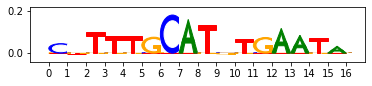

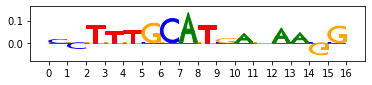

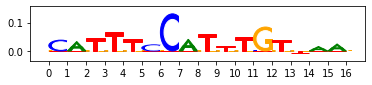

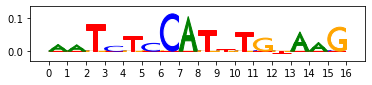

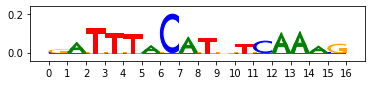

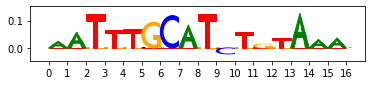

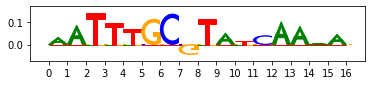

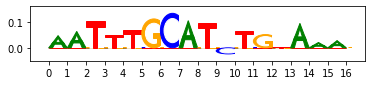

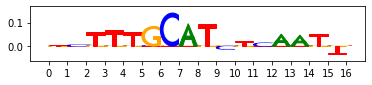

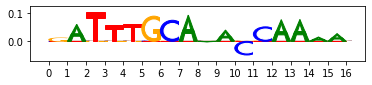

In [23]:
for i in range(10): 
    viz_sequence.plot_weights(high_OSK_shaps[i], figsize=(6,1))

### iPSC data

In [26]:
IPSC_MODISCO_PATH = "/users/surag/oak/projects/scATAC-reprog/bpnet/models/20210820_chrombpnet_lite/chrombpnet/cluster_idx8/modisco/modisco_results_allChroms_counts.hdf5"
IPSC_HDF5_PATH = "/users/surag/oak/projects/scATAC-reprog/bpnet/models/20210820_chrombpnet_lite/chrombpnet/cluster_idx8/interpret/counts_scores.h5"
IPSC_REG_PATH = "/users/surag/oak/projects/scATAC-reprog/bpnet/models/20210820_chrombpnet_lite/chrombpnet/cluster_idx8/interpret/interpreted_regions.bed"

In [27]:
ipsc_modisco = h5py.File(IPSC_MODISCO_PATH, 'r')

In [ ]:
ipsc_imp_scores = deepdish.io.load(IPSC_HDF5_PATH)

In [ ]:
ipsc_regions = get_regions(IPSC_REG_PATH, MODISCO_CROP_WIDTH)

In [ ]:
# patterns

# OS: pattern_1 : 7 - 23

In [ ]:
ipsc_coords, ipsc_is_rc, \
ipsc_subcluster_idxs, \
ipsc_shaps, ipsc_one_hots, \
ipsc_insertions, ipsc_pred_w_bias,\
ipsc_pred_wo_bias = \
        fetch_data(ipsc_modisco, "pattern_1", 7, 23,
                   ipsc_imp_scores, ipsc_regions, 
                   "/users/surag/oak/projects/scATAC-reprog/clusters/20210714_n64913/bigwigs/cluster_idx8.bw", 
                   "/users/surag/oak/projects/scATAC-reprog/bpnet/models/20210820_chrombpnet_lite/chrombpnet/cluster_idx8/predict/cluster_idx8_w_bias.bw",
                   "/users/surag/oak/projects/scATAC-reprog/bpnet/models/20210820_chrombpnet_lite/chrombpnet/cluster_idx8/predict/cluster_idx8_wo_bias.bw",
                   MODISCO_CROP_WIDTH, hg38, rc_everything=False, expand_bw=100)

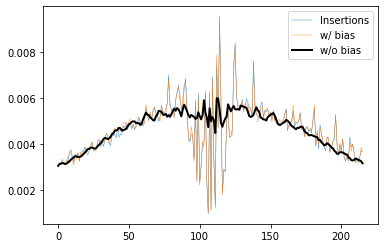

In [32]:
plt.plot(np.array([x/sum(x) for x in ipsc_insertions if sum(x)>0]).mean(0), label="Insertions", linewidth=0.4)
plt.plot(np.array([x/sum(x) for x in ipsc_pred_w_bias]).mean(0), label="w/ bias", linewidth=0.4)
plt.plot(np.array([x/sum(x) for x in ipsc_pred_wo_bias]).mean(0), label="w/o bias", linewidth=2, c='k')
plt.legend()

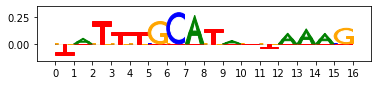

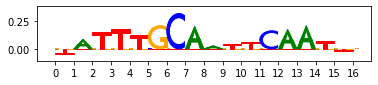

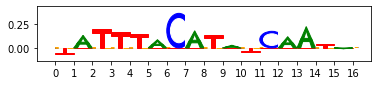

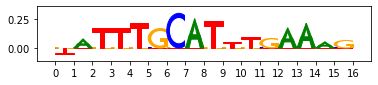

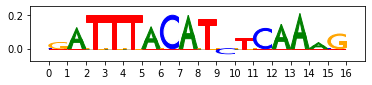

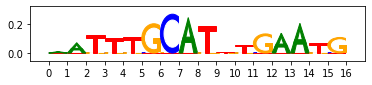

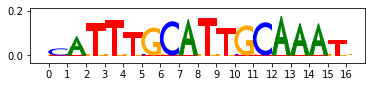

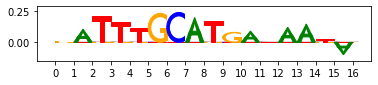

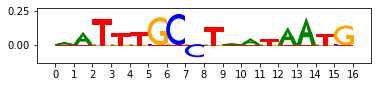

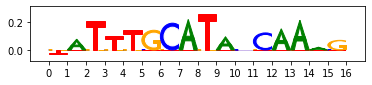

In [33]:
for i in range(10): 
    viz_sequence.plot_weights(ipsc_shaps[i], figsize=(6,1))

## Computing log-odds scores and comparing iPSC vs high OSK motifs

In [34]:
IPSC_OCTONLY_SUBCLUSTER = 2

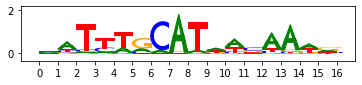

In [35]:
viz_sequence.plot_weights(viz_sequence.ic_scale(ipsc_one_hots.mean(0), background=[0.25]*4), 
                          figsize=(6,1))

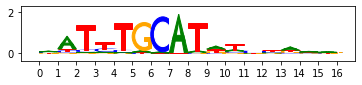

In [36]:
# cluster which is mostly OCT
viz_sequence.plot_weights(viz_sequence.ic_scale(ipsc_one_hots[ipsc_subcluster_idxs==IPSC_OCTONLY_SUBCLUSTER].mean(0), background=[0.25]*4), figsize=(6,1))

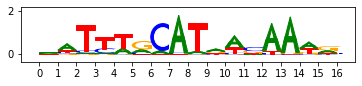

In [37]:
# excluding cluster which is mostly OCT
viz_sequence.plot_weights(viz_sequence.ic_scale(ipsc_one_hots[ipsc_subcluster_idxs!=IPSC_OCTONLY_SUBCLUSTER].mean(0), background=[0.25]*4), 
                          figsize=(6,1))

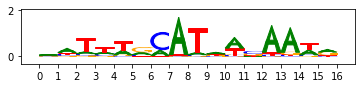

In [38]:
viz_sequence.plot_weights(viz_sequence.ic_scale(high_OSK_one_hots.mean(0), background=[0.25]*4),
                          figsize=(6,1))

In [39]:
from random import sample, randint, shuffle

In [40]:
# exclude OCT only cluster for iPSC
ipsc_one_hots_wo_OCT_only = ipsc_one_hots[ipsc_subcluster_idxs!=IPSC_OCTONLY_SUBCLUSTER]
ipsc_pwm = ipsc_one_hots_wo_OCT_only.sum(0)
ipsc_pwm = ipsc_pwm/np.sum(ipsc_pwm, axis=1, keepdims=True)
ipsc_logodds_mat = np.log(ipsc_pwm/0.25)

high_OSK_pwm = high_OSK_one_hots.sum(0)
high_OSK_pwm = high_OSK_pwm/np.sum(high_OSK_pwm, axis=1, keepdims=True)
high_OSK_logodds_mat = np.log(high_OSK_pwm/0.25)

# equal weight for both
mixed_pwm = (high_OSK_one_hots.sum(0)/high_OSK_one_hots.shape[0]) + (ipsc_one_hots_wo_OCT_only.sum(0)/ipsc_one_hots_wo_OCT_only.shape[0])
mixed_pwm = mixed_pwm/np.sum(mixed_pwm, axis=1, keepdims=True)
mixed_logodds_mat = np.log(mixed_pwm/0.25)

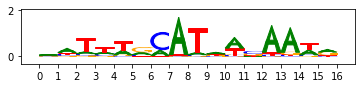

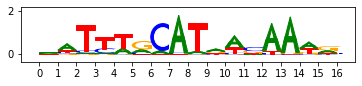

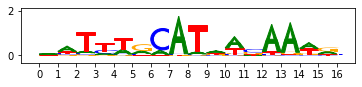

In [41]:
viz_sequence.plot_weights(viz_sequence.ic_scale(high_OSK_pwm, background=[0.25]*4), figsize=(6,1))
viz_sequence.plot_weights(viz_sequence.ic_scale(ipsc_pwm, background=[0.25]*4), figsize=(6,1))
viz_sequence.plot_weights(viz_sequence.ic_scale(mixed_pwm, background=[0.25]*4), figsize=(6,1))

In [42]:
print(np.median(np.sum(high_OSK_one_hots*high_OSK_logodds_mat, axis=(1,2))))
print(np.median(np.sum(high_OSK_one_hots*ipsc_logodds_mat, axis=(1,2))))
print(np.median(np.sum(high_OSK_one_hots*mixed_logodds_mat, axis=(1,2))))

8.035137908761474
7.518118781101658
7.958049325152175


In [43]:
print(np.median(np.sum(ipsc_one_hots_wo_OCT_only*high_OSK_logodds_mat, axis=(1,2))))
print(np.median(np.sum(ipsc_one_hots_wo_OCT_only*ipsc_logodds_mat, axis=(1,2))))
print(np.median(np.sum(ipsc_one_hots_wo_OCT_only*mixed_logodds_mat, axis=(1,2))))

9.550998546600264
10.027481061616035
9.925198571187043


In [44]:
import seaborn as sns

In [46]:
THRESH = 5

to_plot_ipsc = np.sum(ipsc_one_hots_wo_OCT_only*mixed_logodds_mat, axis=(1,2))
to_plot_ipsc = to_plot_ipsc[to_plot_ipsc>THRESH]

to_plot_high_OSK = np.sum(high_OSK_one_hots*mixed_logodds_mat, axis=(1,2))
to_plot_high_OSK = to_plot_high_OSK[to_plot_high_OSK>THRESH]

In [47]:
np.median(to_plot_ipsc), np.median(to_plot_high_OSK)

(9.956307247986341, 8.276358518169829)

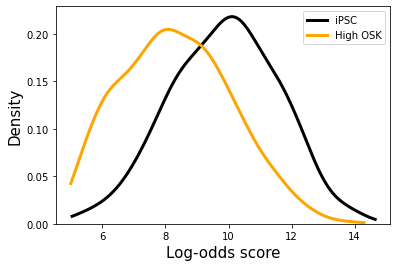

In [48]:
sns.kdeplot(to_plot_ipsc, label='iPSC', cut=0, c='k', linewidth=3, bw_adjust=1.5)
sns.kdeplot(to_plot_high_OSK, label='High OSK', cut=0, c='orange', linewidth=3, bw_adjust=1.5)
plt.xlabel("Log-odds score", fontsize=15)
plt.ylabel("Density", fontsize=15)
plt.legend()
plt.savefig("./subfigs/iPSC_vs_high_OSK_OCTSOX_scores.pdf")
# pd.Series(logodds_p11).hist(bins=50,alpha=0.5)

Text(0, 0.5, 'Log-odds')

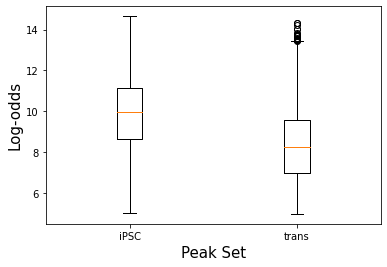

In [49]:
plt.boxplot([to_plot_ipsc,to_plot_high_OSK],
            labels=["iPSC","trans"])
plt.xlabel("Peak Set", fontsize=15)
plt.ylabel("Log-odds", fontsize=15)
# plt.show()
# plt.savefig("tmp.pdf")

In [50]:
import scipy
print(scipy.stats.mannwhitneyu(to_plot_high_OSK, to_plot_ipsc)[1])

1.8442873017745612e-285


## Scoring with BPNet motif

In [54]:
BPNet_OS_pfm = np.loadtxt("../../../resources/BPNet/motifs/Oct4-Sox2/PFM.txt")[::-1,::-1]

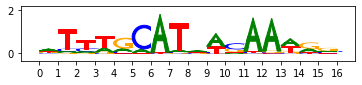

In [55]:
viz_sequence.plot_weights(viz_sequence.ic_scale(BPNet_OS_pfm, background=[0.25]*4), figsize=(6,1))

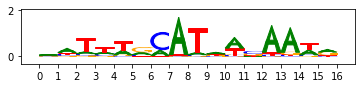

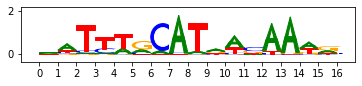

In [56]:
viz_sequence.plot_weights(viz_sequence.ic_scale(high_OSK_pwm, background=[0.25]*4), figsize=(6,1))
viz_sequence.plot_weights(viz_sequence.ic_scale(ipsc_pwm, background=[0.25]*4), figsize=(6,1))

Ignore 1 base on sides of both motifs.

In [57]:
BPNet_OS_logodds = np.log(BPNet_OS_pfm[:-1]/0.25)

In [113]:
THRESH = 4

to_plot_ipsc = np.sum(ipsc_one_hots_wo_OCT_only[:,1:]*BPNet_OS_logodds, axis=(1,2))
to_plot_ipsc = to_plot_ipsc[to_plot_ipsc>THRESH]

to_plot_high_OSK = np.sum(high_OSK_one_hots[:,1:]*BPNet_OS_logodds, axis=(1,2))
to_plot_high_OSK = to_plot_high_OSK[to_plot_high_OSK>THRESH]

In [114]:
np.median(to_plot_ipsc), np.median(to_plot_high_OSK)

(9.796314957770903, 7.856754420307107)

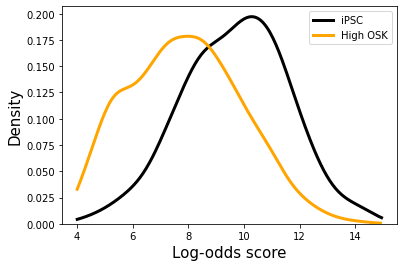

In [119]:
sns.kdeplot(to_plot_ipsc, label='iPSC', cut=0, c='k', linewidth=3, bw_adjust=1.5)
sns.kdeplot(to_plot_high_OSK, label='High OSK', cut=0, c='orange', linewidth=3, bw_adjust=1.5)
plt.xlabel("Log-odds score", fontsize=15)
plt.ylabel("Density", fontsize=15)
plt.legend()
plt.savefig("./subfigs/iPSC_vs_high_OSK_OCTSOX_scores_wrt_BPNet_motif.pdf")
# pd.Series(logodds_p11).hist(bins=50,alpha=0.5)

In [120]:
all_cts = Counter(high_OSK_subcluster_idxs)
thresh_cts = Counter(high_OSK_subcluster_idxs[np.sum(high_OSK_one_hots[:,1:]*BPNet_OS_logodds, axis=(1,2)) > THRESH])
for x in range(10):
    print("{:.2f}\t{:d}".format(thresh_cts[x]/all_cts[x], all_cts[x]))

0.83	2115
0.91	1648
0.93	1638
0.98	1519
0.92	1386
0.96	506
0.84	215
0.94	210
0.63	146
0.92	60


In [121]:
import scipy
print(scipy.stats.mannwhitneyu(to_plot_high_OSK, to_plot_ipsc)[1])

0.0
